In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## Data Exploration

In [2]:
# loading in data
df = pd.read_csv("/mnt/scratch/tairaeli/cse_dat/train.csv")

# df['bid_ask_ratio'] = df['bid_size']/df['ask_size']

df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [3]:
df.shape

(5237980, 17)

In [4]:
# calulate ratio
df['bid_ask_ratio'] = df['bid_size']/df['ask_size']

df["target_change"] = np.ones_like(df["target"])

df.loc[df["target"]<0,'target_change'] = -1

df = df.drop(["target","bid_price","ask_price","row_id"], axis=1)

In [5]:
df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_size', 'ask_size', 'wap', 'time_id',
       'bid_ask_ratio', 'target_change'],
      dtype='object')

To better understand the data we are working with, we beign by plotting the correlation of each predictor with one another

Text(0.5, 1.0, 'Optiver Data Correlation Matrix')

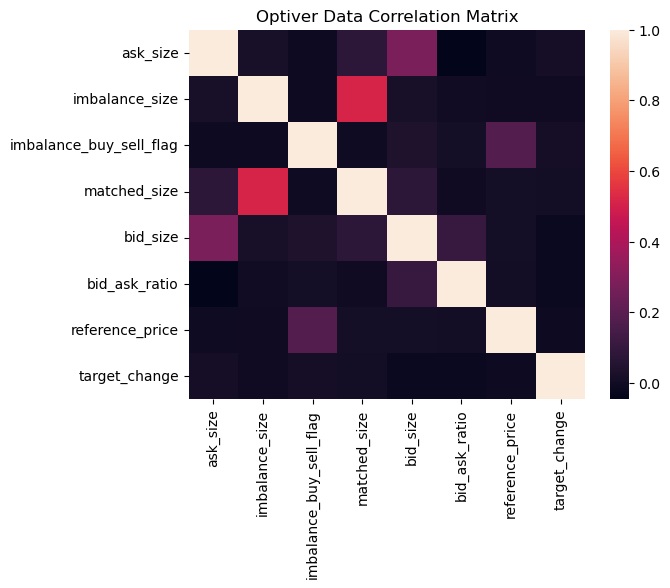

In [33]:
# isolating numerical values
num_vals = df[['ask_size', 'imbalance_size', 'imbalance_buy_sell_flag', 'matched_size', 'bid_size', 'bid_ask_ratio', 'reference_price','target_change']]
# starting by removing NaN values from dataset
# we can try some more complex methods later on
num_vals = num_vals.dropna()

# creating heatmap
corr_plot = sns.heatmap(num_vals.corr())
plt.title("Optiver Data Correlation Matrix")

In [34]:
num_vals.corr()

,ask_size,imbalance_size,imbalance_buy_sell_flag,matched_size,bid_size,bid_ask_ratio,reference_price,target_change
ask_size,1.000000,0.022623,-0.013356,0.079209,0.278326,-0.046666,-0.006528,0.014461
imbalance_size,0.022623,1.000000,-0.010159,0.512367,0.021141,-0.000928,-0.003717,-0.001719
imbalance_buy_sell_flag,-0.013356,-0.010159,1.000000,-0.006003,0.035236,0.009101,0.182100,0.013568
matched_size,0.079209,0.512367,-0.006003,1.000000,0.078554,-0.003421,0.007724,0.002510
bid_size,0.278326,0.021141,0.035236,0.078554,1.000000,0.106981,0.007271,-0.017563
bid_ask_ratio,-0.046666,-0.000928,0.009101,-0.003421,0.106981,1.000000,0.005937,-0.020757
reference_price,-0.006528,-0.003717,0.182100,0.007724,0.007271,0.005937,1.000000,-0.009893
target_change,0.014461,-0.001719,0.013568,0.002510,-0.017563,-0.020757,-0.009893,1.000000


To begin with we create a simple linear model using the full feature space to act as our baseline

## Baseline Model

The respone is super tight around 1. Seems like we will need to normalize the data so that we can actually use it for our analysis

In [6]:
# trying a thing
st0 = df[df["stock_id"] == 0]

st0 = st0.drop(["stock_id","time_id","reference_price","far_price","near_price","date_id"], axis = 1)

st0.head()

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,matched_size,bid_size,ask_size,wap,bid_ask_ratio,target_change
0,0,3180602.69,1,13380276.64,60651.50,8493.03,1.000000,7.141326,-1.0
191,10,1299772.70,1,15261106.63,13996.50,23519.16,0.999892,0.595111,1.0
382,20,1299772.70,1,15261106.63,4665.50,12131.60,0.999842,0.384574,1.0
573,30,1299772.70,1,15261106.63,55998.00,46203.30,1.000085,1.211991,1.0
764,40,1218204.43,1,15342674.90,14655.95,26610.45,1.000317,0.550759,1.0


In [7]:
# creating test-train split
X = st0.drop(["target_change"], axis = 1)

# created response variable array
y = st0["target_change"]

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2)

In [8]:
# creating model with fit
lmod = LogisticRegression()
lmod.fit(X_tr,y_tr)

LogisticRegression()

In [9]:
# generating predictions
y_hat = lmod.predict(X_tst)

# finding rmse of the baseline model
baseline_score = accuracy_score(y_tst, y_hat)
print(baseline_score)

0.5171045171045171


In [10]:
confusion_matrix(y_tst, y_hat, normalize='all')

array([[0.3951994 , 0.11283311],
       [0.37006237, 0.12190512]])

In [15]:
import matplotlib.ticker as ticker
%matplotlib inline

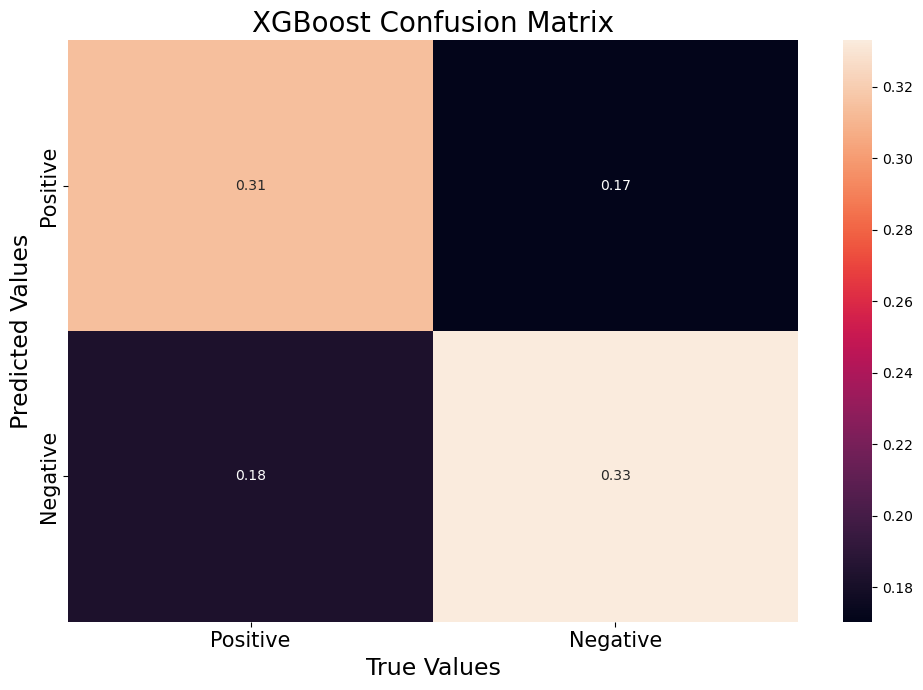

In [45]:
# cm = confusion_matrix(y_tst, y_hat , normalize='all')
cm = np.array([[0.31407035, 0.17043551],
               [0.18257956, 0.33291457]])
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True)
ax.set_xlabel("True Values",fontsize=17)
ax.set_ylabel("Predicted Values",fontsize=17)
ax.set_xticklabels(["Positive","Negative"], fontsize=15)
ax.set_yticklabels(["Positive","Negative"],fontsize=15)
ax.set_title("XGBoost Confusion Matrix", fontsize=20)
plt.tight_layout()

In [43]:
vals = np.array([2168, 548, 2003, 572])

vals/np.sum(vals)

array([0.40975241, 0.1035721 , 0.37856738, 0.10810811])

In [44]:
f1_score(y_tst, y_hat)

0.2773109243697479

In [45]:
# creating feature selection model
bes = SequentialFeatureSelector(LogisticRegression(), 
                                direction="forward")

# perfoming model fit
bes.fit(X_tr, y_tr)

# printing optimal feat
pred_bet_feature_set = bes.get_feature_names_out()
print(pred_bet_feature_set)

['seconds_in_bucket' 'imbalance_size' 'bid_size' 'ask_size']


In [46]:
X_tr = X_tr[pred_bet_feature_set]
X_tst = X_tst[pred_bet_feature_set]

lmod = LogisticRegression()

lmod.fit(X_tr,y_tr)

lmod_preds = lmod.predict(X_tst)

# rmse with removed features
acc_subset = accuracy_score(y_tst, y_hat)
print(acc_subset)

0.5123795123795124
